In [17]:
import numpy as np #
import pickle #
import glob #
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler #
from imblearn import combine, over_sampling, under_sampling #ADASYN, SMOTE, SMOTENC #
import pandas as pd
import xgboost
from xgboost import plot_tree
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error, f1_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.impute import SimpleImputer

import shap
sns.set() # setting seaborn default for plots
%matplotlib inline


In [11]:
class XGBCLASS:
    def __init__(self,train_file='./train.csv',test_file='./test.csv'):
        
        #data
        self.train_data=pd.read_csv(train_file)
        self.test_data=pd.read_csv(test_file)
        self.train_data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
        self.test_data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
        self.y= self.train_data['Recurrence']
        self.X = self.train_data.drop(['Recurrence'],axis=1)
        smt = combine.SMOTEENN(random_state=1)
        self.X, self.y = smt.fit_resample(self.X,self.y)
        
        column_list=['Postop_pneumonia,_pleural_effusion,_edema',
           'number_of_total_positive_lymph_node',
           'BMI',
           'Site_of_tumor(complex)',
           'Distant_metastasis',
           'Postop_RT',
           'preop_RT',
           'Age',
           'CA19-9',
           'Perforation',
           'Postop_bleeding',
           'Emergency',
           'Fistula',
           'number_of_harvested_lymph_node', #토탈?
           'Postop_chemotherapy',
           'Gender',
           'CEA',
           'Tstage',
           'Postop_intraop_abscess',
           'Type_of_operation',
           'Colonic_obstruction',
           'Type_of_Chemotherapy',
           'Duration_of_op',
           'LVI',
           'Postop_intestinal_obstruction',
           'Prev._Abd_OP_history',
           'Operation',
           'Postop_leakage',
           'Tumor_size(major)',
           'neural_invasion',
           'Intraoperative_Transfusion',
           'Differentiation',
           'Histologis_classification'
          ]
        self.X=self.X[column_list]
        

        
        
        self.train_X, self.val_X, self.train_y, self.val_y = train_test_split(self.X, self.y, test_size=0.1, shuffle=True, random_state=1)
        self.test_X =self.test_data.drop(['Recurrence'],axis=1)
        self.test_X=self.test_X[column_list]
        self.test_y =self.test_data['Recurrence']
        self.pred=[]
        
        #params
        self.params={
            'learning_rate':0.1,
            'n_estimators':1000,
            'max_depth':5,
            'min_child_weight':1,
            'gamma':0,
            'subsample':0.8,
            'colsample_bytree':0.8,
            'objective':'binary:logistic',
            'nthread':-1,
            'scale_pos_weight':1,
            'seed':2019,
            'reg_alpha':1e-5
        }
        self.model=xgboost.XGBClassifier(
            learning_rate =self.params['learning_rate'],
            n_estimators=self.params['n_estimators'],
            max_depth=self.params['max_depth'],
            min_child_weight=self.params['min_child_weight'],
            gamma=self.params['gamma'],
            subsample=self.params['subsample'],
            colsample_bytree=self.params['colsample_bytree'],
            objective= self.params['objective'],
            nthread=self.params['nthread'],
            scale_pos_weight=self.params['scale_pos_weight'],
            seed=self.params['seed']
        )
    
    def set_model(self):
        self.model=xgboost.XGBClassifier(
            learning_rate =self.params['learning_rate'],
            n_estimators=self.params['n_estimators'],
            max_depth=self.params['max_depth'],
            min_child_weight=self.params['min_child_weight'],
            gamma=self.params['gamma'],
            subsample=self.params['subsample'],
            colsample_bytree=self.params['colsample_bytree'],
            objective= self.params['objective'],
            nthread=self.params['nthread'],
            scale_pos_weight=self.params['scale_pos_weight'],
            seed=self.params['seed']
        )

    def test(self,y,pred):
        rmse=np.sqrt(mean_squared_error(y,pred))
        print('RMSE: %f' %(rmse))
        print('Accuracy_score: ', metrics.accuracy_score(y,pred))
        print('F-score:',f1_score(y,pred))
        
    def model_fit(self):
        self.model.fit(self.train_X,self.train_y)
        val_preds=self.model.predict(self.val_X)
        test_preds=self.model.predict(self.test_X)
        self.pred=[val_preds,test_preds]
        print("평가 데이터 Acc:")
        self.test(self.val_y,val_preds)
        print("시험 데이터 Acc:")
        self.test(self.test_y,test_preds)
        
#         return val_preds, test_preds
    
    def tuning_param(self,xgb_param_grid):
        hr_grid = GridSearchCV(estimator=self.model,
                               param_grid=xgb_param_grid,
                               scoring='accuracy',
                               n_jobs=32,
                               cv=5,
                               refit=True, 
                               verbose=10,
                               return_train_score=True)
        hr_grid.fit(self.train_X,self.train_y)
        # print(hr_grid.cv_results_, hr_grid.best_params_, hr_grid.best_score_)
        print("최고의 파라미터",hr_grid.best_params_, hr_grid.best_score_)

In [12]:
xgb_model=XGBCLASS()
xgb_model.model_fit()


평가 데이터 Acc:
RMSE: 0.283552
Accuracy_score:  0.9195979899497487
F-score: 0.9370078740157481
시험 데이터 Acc:
RMSE: 0.529150
Accuracy_score:  0.72
F-score: 0.7142857142857142


In [14]:
# # 초모수 격자생성
# xgb_param_grid = {'max_depth':range(3,10,3),
#                   'min_child_weight':range(1,6,2),
#                   'gamma':[i/10.0 for i in range(0,5)],
#                   'subsample':[i/10.0 for i in range(6,10)],
#                   'colsample_bytree':[i/10.0 for i in range(6,10)],
#                   'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
#                  }
# # Create a GridSearchCV object
# xgb_model.set_model()
# xgb_model.tuning_param(xgb_param_grid)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits
최고의 파라미터 {'colsample_bytree': 0.7, 'gamma': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 0.01, 'subsample': 0.6} 0.9184790611060587


In [15]:
#최고의 파라미터 {'colsample_bytree': 0.7, 'gamma': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 0.01, 'subsample': 0.6} 0.9184790611060587

xgb_model.params['n_estimators']=1000
xgb_model.params['learning_rate']=0.01
xgb_model.params['reg_alpha']=0.01
xgb_model.params['colsample_bytree']=0.7
xgb_model.params['subsample']=0.6
xgb_model.params['gamma']=0.1
xgb_model.params['max_depth']=6
xgb_model.params['min_child_weight']=1


xgb_model.set_model()
xgb_model.model_fit()

평가 데이터 Acc:
RMSE: 0.297955
Accuracy_score:  0.9112227805695142
F-score: 0.9303547963206308
시험 데이터 Acc:
RMSE: 0.529150
Accuracy_score:  0.72
F-score: 0.7142857142857142


In [18]:
shap.initjs()
explainer=shap.TreeExplainer(xgb_model.model)
shap_values=explainer.shap_values(xgb_model.train_X)

In [19]:
xgb_model.train_X.head()

,"Postop_pneumonia,_pleural_effusion,_edema",number_of_total_positive_lymph_node,BMI,Site_of_tumor(complex),Distant_metastasis,Postop_RT,preop_RT,Age,CA19-9,Perforation,...,LVI,Postop_intestinal_obstruction,Prev._Abd_OP_history,Operation,Postop_leakage,Tumor_size(major),neural_invasion,Intraoperative_Transfusion,Differentiation,Histologis_classification
3495,0,0.071508,23.900111,8,0,0.0,0,68,7.742683,0,...,0,0,0,5,0,5.928492,1,0,2,1.0
3300,0,0.334210,23.900526,2,0,0.0,0,39,1.169472,0,...,0,0,0,2,0,4.782763,0,0,2,1.0
2764,0,4.000000,23.500000,9,0,0.0,0,67,5.600000,0,...,1,0,0,5,0,4.000000,0,0,2,1.0
5099,0,0.575263,23.122053,8,0,0.0,0,64,37.625789,0,...,0,0,0,6,0,3.172579,0,0,2,1.0
1475,0,0.000000,22.500000,9,0,0.0,0,60,2.300000,0,...,0,0,0,6,0,3.500000,0,0,1,1.0


In [20]:
xgb_model.train_y[4402]

1

In [21]:
xgb_model.train_X.iloc[4402,:]

Postop_pneumonia,_pleural_effusion,_edema      0.000000
number_of_total_positive_lymph_node            4.666154
BMI                                           23.002153
Site_of_tumor(complex)                         5.000000
Distant_metastasis                             0.000000
Postop_RT                                      0.000000
preop_RT                                       0.000000
Age                                           69.000000
CA19-9                                        17.998462
Perforation                                    0.000000
Postop_bleeding                                0.000000
Emergency                                      0.000000
Fistula                                        0.000000
number_of_harvested_lymph_node                13.330770
Postop_chemotherapy                            1.000000
Gender                                         2.000000
CEA                                            2.632923
Tstage                                         3

In [22]:
shap.force_plot(explainer.expected_value,shap_values[0,:],xgb_model.train_X.iloc[4402,:])

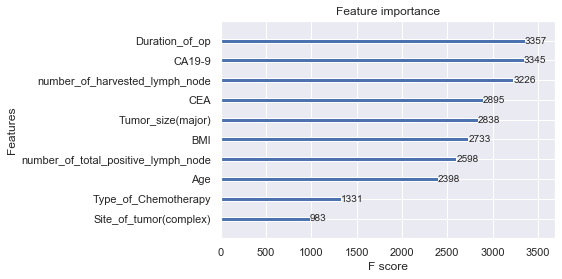

In [23]:
xgboost.plot_importance(xgb_model.model, max_num_features=10) 

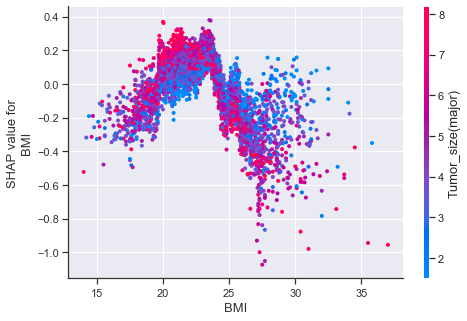

In [24]:
shap.dependence_plot("BMI", shap_values, xgb_model.train_X)

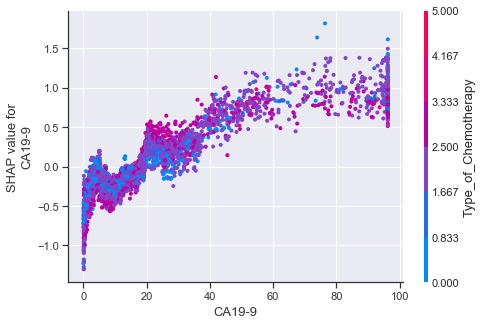

In [25]:
shap.dependence_plot("CA19-9", shap_values, xgb_model.train_X)

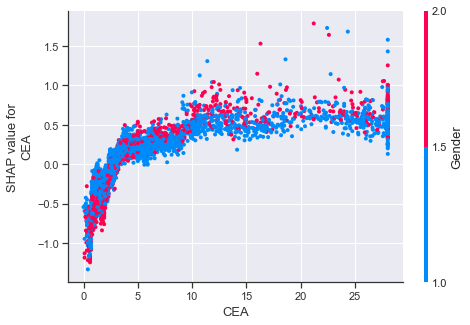

In [26]:
shap.dependence_plot("CEA", shap_values, xgb_model.train_X)

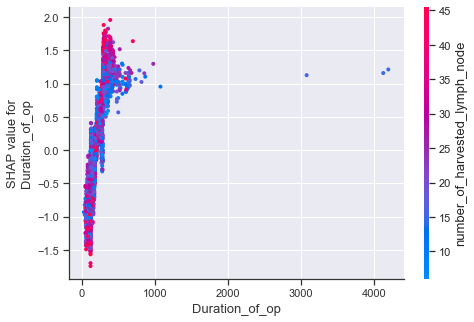

In [27]:
shap.dependence_plot("Duration_of_op", shap_values, xgb_model.train_X)

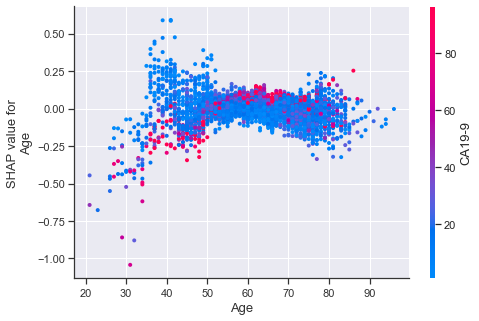

In [28]:
shap.dependence_plot("Age", shap_values, xgb_model.train_X)

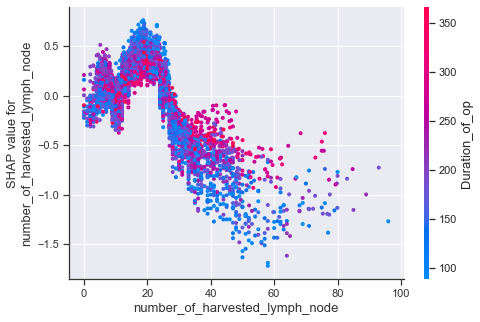

In [29]:
shap.dependence_plot("number_of_harvested_lymph_node", shap_values, xgb_model.train_X)

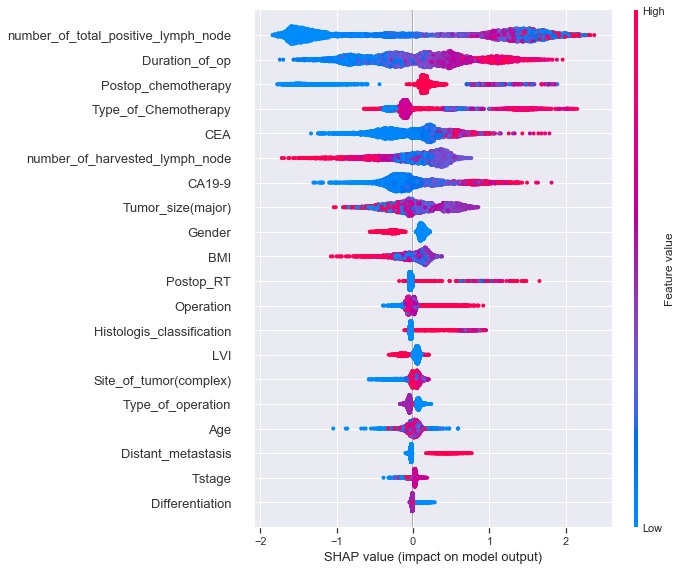

In [30]:
shap.summary_plot(shap_values, xgb_model.train_X)